In [2]:
import sys
import os

# Fix relative import issue, append root path to sys.path
parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent)

In [ ]:
from core.dataset import MoleculeDataset
from core.trainer import ModelTrainer
from models import SimpleMoleculeGCN, AdvancedMoleculeGNN

import torch
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

from core.utils import *

In [5]:
set_seed()

In [ ]:
dataset = load_dataset('../data/raw/ESOL.csv', target_col='measured log solubility in mols per litre')
dataset = [data for data in dataset if data is not None]

train_dataset, temp = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp, test_size=0.5, random_state=42)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
num_node_features = MoleculeDataset._N_NODE_FEATURES  # Based on get_atom_features (grabbed only 6 feature, have to increase)
num_edge_feature = MoleculeDataset._N_EDGE_FEATURES  

modelGCN = SimpleMoleculeGCN(
    num_node_features=num_node_features,
    hidden_dim=128,
    num_classes=1
)

modelGNN = AdvancedMoleculeGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_feature, 
    hidden_dim=128,
    num_classes=1
)

model = modelGNN
model_list = [modelGCN, modelGNN]

[count_parameters(model) for model in model_list]

[43009, 93057]

In [13]:
trainer = ModelTrainer(model)
trainer.fit(
    train_loader, 
    val_loader, 
    epochs=5, 
    lr=0.001,
    task='classification',
    patience=15
)

criterion = torch.nn.BCEWithLogitsLoss()
test_loss, test_metric, metric_name = trainer.evaluate(test_loader, criterion, 'classification')
print(f'\nTest Results: Loss: {test_loss:.4f}, {metric_name}: {test_metric:.4f}')

Training: 100%|██████████| 25/25 [00:03<00:00,  8.21it/s]


Epoch 001: Train Loss: -116.4238, Val Loss: -648.9662, Val ROC-AUC: 0.7068


Training: 100%|██████████| 25/25 [00:02<00:00, 12.47it/s]


Epoch 002: Train Loss: -1529.8901, Val Loss: -6992.8781, Val ROC-AUC: 0.4488


Training: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


Epoch 003: Train Loss: -9358.0285, Val Loss: -27785.0369, Val ROC-AUC: 0.5321


Training: 100%|██████████| 25/25 [00:01<00:00, 13.22it/s]


Epoch 004: Train Loss: -33741.3700, Val Loss: -111025.6518, Val ROC-AUC: 0.4367


Training: 100%|██████████| 25/25 [00:01<00:00, 13.99it/s]

Epoch 005: Train Loss: -91097.0265, Val Loss: -237613.2940, Val ROC-AUC: 0.5000
Training completed. Best validation loss: -237613.2940

Test Results: Loss: -213397.0464, ROC-AUC: 0.5000


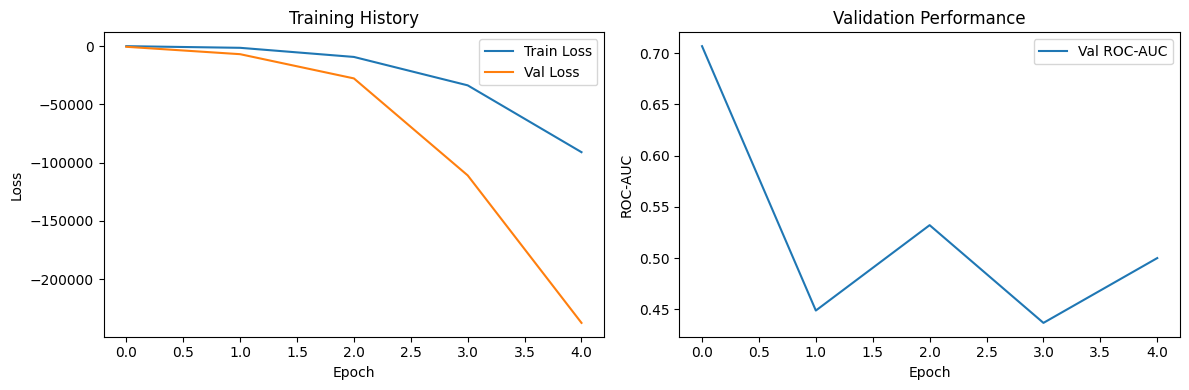

In [14]:
import matplotlib.pyplot as plt
    
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trainer.history['train_loss'], label='Train Loss')
plt.plot(trainer.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')

plt.subplot(1, 2, 2)
plt.plot(trainer.history['val_metric'], label='Val ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.title('Validation Performance')

plt.tight_layout()
plt.show()